In [86]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [87]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# CIFAR10


In [88]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.CIFAR10(root='./data', train=True,  download=True,transform=trans)
test_set = dset.CIFAR10(root='./data', train=False, transform=trans)

Files already downloaded and verified


In [89]:
BATCH_SIZE=64
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

In [90]:
batch=next(iter(train_loader))
print(batch[0].size())
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)



torch.Size([64, 3, 32, 32])
(50000, 32, 32, 3)
(10000, 32, 32, 3)


# VGG16

In [91]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 1024),
            nn.Linear(1024, 2048),
            nn.Dropout(),
            nn.Linear(2048, 10)
        )

        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

In [92]:
def test(model, test_loader, criterion):
    model.eval()
    test_losses = []
    test_accuracies = []



    for _, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        test_accuracies.append(accuracy)

    return np.mean(test_losses), np.mean(test_accuracies)

In [93]:
def train(model, train_loader, optimizer, criterion,epochs):
    train_losses = []
    test_losses = []
    test_accuracies = []

    model.train()

    for epoch in range(EPOCHS):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            if i%100==0:

                tl, ta = test(model, test_loader, criterion)
                test_losses.append(tl)
                test_accuracies.append(ta)

                print(f'\nEpoch {epoch+1}/{EPOCHS}, Step {i+1}/{len(train_loader)}\n - Train Loss: {loss.item()}')
                print(f' - Test Loss: {tl}\n - Test Accuracy: {ta}')


    return train_losses, test_losses, test_accuracies



In [94]:
model = VGG16().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS=3

losses, test_losses, test_accuracies = train(model, train_loader, optimizer, criterion,EPOCHS)


Epoch 1/3, Step 1/782
 - Train Loss: 2.304152011871338
 - Test Loss: 3.7404793690723976
 - Test Accuracy: 0.09952229299363058

Epoch 1/3, Step 101/782
 - Train Loss: 2.1138148307800293
 - Test Loss: 1.9922495070536426
 - Test Accuracy: 0.2425358280254777

Epoch 1/3, Step 201/782
 - Train Loss: 1.6901512145996094
 - Test Loss: 1.6984677466617268
 - Test Accuracy: 0.35240843949044587

Epoch 1/3, Step 301/782
 - Train Loss: 1.6376599073410034
 - Test Loss: 1.5381579482631318
 - Test Accuracy: 0.41938694267515925

Epoch 1/3, Step 401/782
 - Train Loss: 1.5787830352783203
 - Test Loss: 1.4632605025722722
 - Test Accuracy: 0.4468550955414013

Epoch 1/3, Step 501/782
 - Train Loss: 1.481456995010376
 - Test Loss: 1.371297091435475
 - Test Accuracy: 0.49572054140127386

Epoch 1/3, Step 601/782
 - Train Loss: 1.3620023727416992
 - Test Loss: 1.3032265833229015
 - Test Accuracy: 0.5169187898089171

Epoch 1/3, Step 701/782
 - Train Loss: 1.3680304288864136
 - Test Loss: 1.319181201943926
 - Test

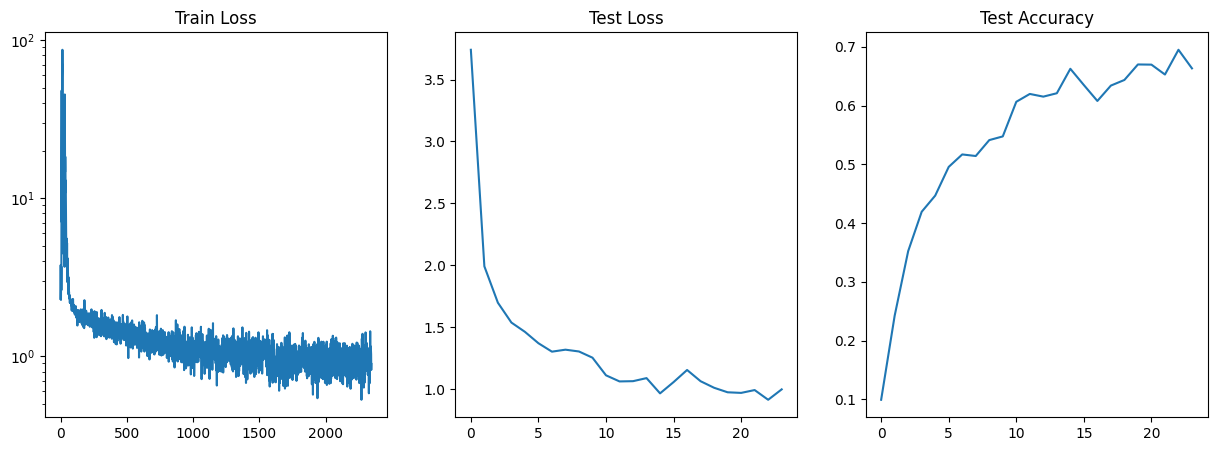

Best Test Loss: 0.914743844870549
Best Test Accuracy: 0.6949641719745223


In [95]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.yscale('log')
plt.title("Train Loss")

plt.subplot(1, 3, 2)
plt.plot(test_losses)
plt.title("Test Loss")

plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.show()


print(f"Best Test Loss: {np.min(test_losses)}")
print(f"Best Test Accuracy: {np.max(test_accuracies)}")